<a href="https://colab.research.google.com/github/thoulden/AI_Research/blob/main/TomH_SEG_Sims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Compute Growth

<ipython-input-122-f988717c136a>:65: RuntimeWarning: divide by zero encountered in scalar divide
  C[t] = C[t-1] * (1+ delta_t * g * beta_0_sample / (lambda_sample * (1-alpha)))
<ipython-input-122-f988717c136a>:70: RuntimeWarning: overflow encountered in scalar multiply
  S_valuesA[t] = S_valuesA[t - 1] + delta_t * Researchers[t-1] ** (lambda_sample * alpha) * C[t-1] ** (lambda_sample * (1-alpha)) * S_valuesA[t - 1] ** (1 - beta_SA[t])
<ipython-input-122-f988717c136a>:71: RuntimeWarning: overflow encountered in scalar multiply
  Researchers[t] = (R_bar + upsilon * S_valuesA[t])


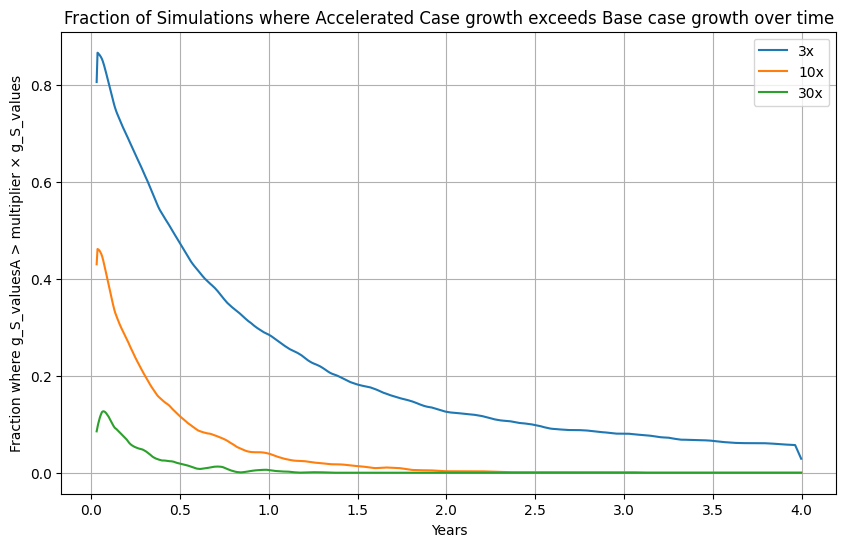

In [ ]:

# Simulation settings
delta_t = 0.001  # Time step in years
T = 4            # Total simulation time in years
time = np.arange(0, T, delta_t)  # Time vector
num_steps = len(time)

# Parameters for distributions
lambda_min, lambda_max = 0.2, 0.8
D_min, D_max = 1e7, 1e11
beta_0_min, beta_0_max = 0.15, 0.75
f_min, f_max = 2, 32

# Fixed parameters
R_bar = 1
C_0 = 1
g = 2.77
alpha=1

# Number of simulations
num_simulations = 1000  # Adjust based on your computational resources

# Define the multipliers
multipliers_2 = [3, 10, 30]    # For the second CDF

# Initialize counts over time for each multiplier
counts_over_time_2 = np.zeros((len(multipliers_2), num_steps - 1))

# Loop over simulations
for sim in range(num_simulations):
    # Sample parameters from log-uniform distributions
    lambda_sample = np.exp(np.random.uniform(np.log(lambda_min), np.log(lambda_max)))
    D_sample = np.exp(np.random.uniform(np.log(D_min), np.log(D_max)))
    beta_0_sample = np.exp(np.random.uniform(np.log(beta_0_min), np.log(beta_0_max)))
    f_sample = np.exp(np.random.uniform(np.log(f_min), np.log(f_max)))

    # Compute derived parameters
    S_bar = (g * R_bar ** (-lambda_sample * alpha) * C_0 ** (-lambda_sample * (1-alpha))) ** (-1 / beta_0_sample)
    R0 = f_sample ** (1 / (lambda_sample * alpha)) * R_bar
    upsilon = R_bar * (f_sample ** (1 / (lambda_sample * alpha)) - 1) / S_bar

    # Initialize arrays
    C = np.zeros(num_steps)
    Researchers = np.zeros(num_steps)
    S_valuesA = np.zeros(num_steps)
    beta_SA = np.zeros(num_steps)
    g_S_valuesA = np.zeros(num_steps - 1)
    S_values = np.zeros(num_steps)
    beta_S = np.zeros(num_steps)
    g_S_values = np.zeros(num_steps - 1)
    S_values_Exp = np.zeros(num_steps)

    # Initial conditions
    C[0] = C_0
    S_valuesA[0] = S_bar
    beta_SA[0] = beta_0_sample
    S_values[0] = S_bar
    beta_S[0] = beta_0_sample
    S_values_Exp[0] = S_bar
    Researchers[0] = f_sample ** (1/(lambda_sample * alpha)) * R_bar

    # Simulation loop
    for t in range(1, num_steps):
      # Non-accelerated case
      beta_S[t] = beta_0_sample * (1 - ((S_values[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      C[t] = C[t-1] * (1+ delta_t * g * beta_0_sample / (lambda_sample * (1-alpha)))
      S_values[t] = S_values[t - 1] + delta_t * (R_bar ** (lambda_sample * alpha))* (C[t-1] ** (lambda_sample * (1-alpha))) * (S_values[t - 1] ** (1- beta_S[t-1]))

      # Accelerated case
      beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_valuesA[t] = S_valuesA[t - 1] + delta_t * Researchers[t-1] ** (lambda_sample * alpha) * C[t-1] ** (lambda_sample * (1-alpha)) * S_valuesA[t - 1] ** (1 - beta_SA[t])
      Researchers[t] = (R_bar + upsilon * S_valuesA[t])

      # Exponential case
      S_values_Exp[t] = S_values_Exp[t - 1] * (1 + delta_t * g)

    # Calculate growth rates
    S_valuesA_netend = S_valuesA[:-1]
    g_S_valuesA = np.diff(S_valuesA) / (S_valuesA_netend * delta_t)
    S_values_netend = S_values[:-1]
    g_S_values = np.diff(S_values) / (S_values_netend * delta_t)

    # Collect counts over time for the first case
    #for m_idx, multiplier in enumerate(multipliers):
     #   counts_over_time[m_idx] += g_S_valuesA > multiplier * 2.77

    # Collect counts over time for the second case
    for m_idx, multiplier in enumerate(multipliers_2):
        counts_over_time_2[m_idx] += g_S_valuesA > multiplier * g_S_values

# Calculate the fractions (CDF) over time
fractions_over_time_2 = counts_over_time_2 / num_simulations

# Apply smoothing to the fractions_over_time using a moving average filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Define the window size for smoothing (adjust as needed)
window_size = 70  # For example, using a window size of 70 time steps

# Apply smoothing to each multiplier's data (second case)
fractions_smoothed_2 = np.zeros_like(fractions_over_time_2)
for m_idx in range(len(multipliers_2)):
    fractions_smoothed_2[m_idx] = moving_average(fractions_over_time_2[m_idx], window_size)

# Create a time mask to exclude data before a certain time
time_mask = time[:-1] >= 0.03  # Exclude data before 0.05 years


# Plot the smoothed CDFs (Second Case)
plt.figure(figsize=(10, 6))
for m_idx, multiplier in enumerate(multipliers_2):
    plt.plot(time[:-1][time_mask], fractions_smoothed_2[m_idx][time_mask], label=f'{multiplier}x')
plt.xlabel('Years')
plt.ylabel('Fraction where g_S_valuesA > multiplier × g_S_values')
plt.title('Fraction of Simulations where Accelerated Case growth exceeds Base case growth over time')
plt.legend()
plt.grid(True)
plt.show()

Old With Researchers Growth


<ipython-input-63-6de683818dbf>:63: RuntimeWarning: overflow encountered in scalar multiply
  S_valuesA[t] = S_valuesA[t - 1] + delta_t * (R_bar + upsilon * S_valuesA[t - 1]) ** lambda_sample * S_valuesA[t - 1] ** (1 - beta_SA[t])
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
<ipython-input-63-6de683818dbf>:62: RuntimeWarning: overflow encountered in scalar divide
  beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)


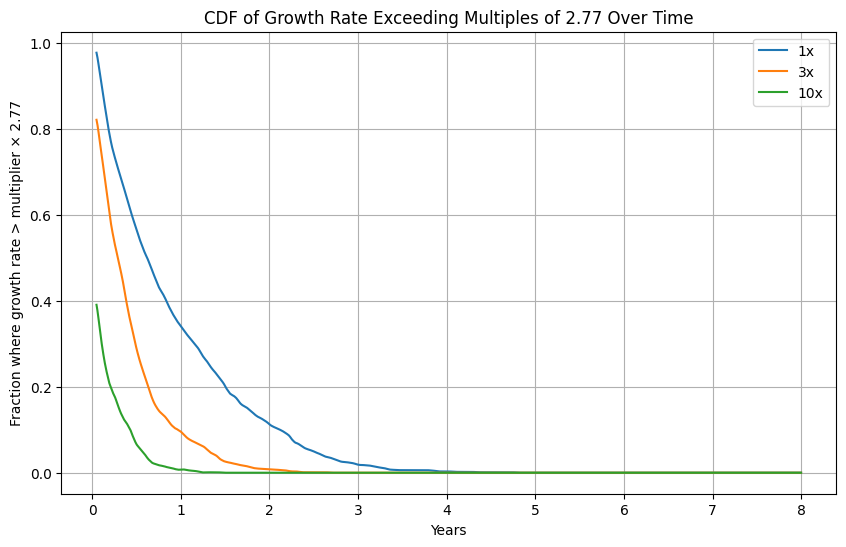

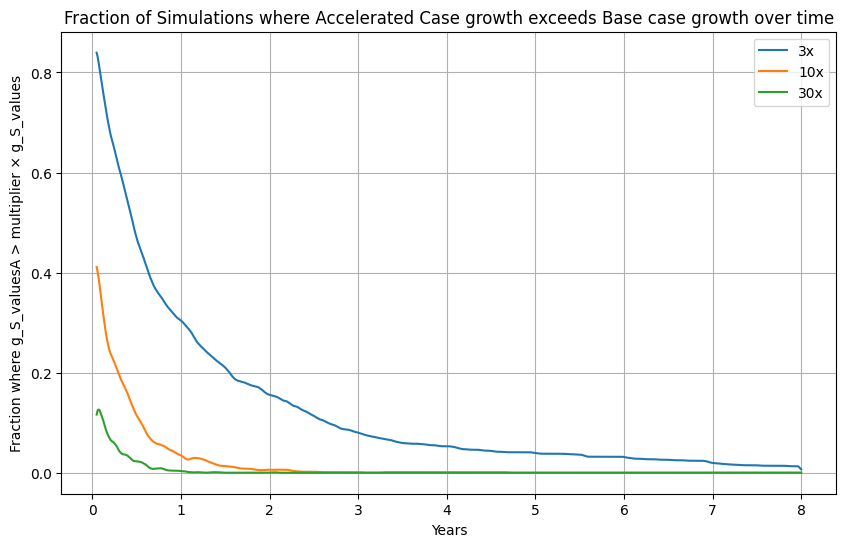

In [ ]:

# Simulation settings
delta_t = 0.001  # Time step in years
T = 8            # Total simulation time in years
time = np.arange(0, T, delta_t)  # Time vector
num_steps = len(time)

# Time points of interest (in years)
time_points = [1/12, 4/12, 1, 3]  # 1 month, 4 months, 1 year, 3 years

# Parameters for distributions
lambda_min, lambda_max = 0.2, 0.8
D_min, D_max = 1e7, 1e11
beta_0_min, beta_0_max = 0.15, 0.75
f_min, f_max = 2, 32

# Fixed parameters
R_bar = 1
g = 2.77
alpha=0.5

# Number of simulations
num_simulations = 1000  # Adjust based on your computational resources

# Define the multipliers
multipliers = [1, 3, 10]       # For the first CDF
multipliers_2 = [3, 10, 30]    # For the second CDF

# Initialize counts over time for each multiplier
counts_over_time = np.zeros((len(multipliers), num_steps - 1))
counts_over_time_2 = np.zeros((len(multipliers_2), num_steps - 1))

# Loop over simulations
for sim in range(num_simulations):
    # Sample parameters from log-uniform distributions
    lambda_sample = np.exp(np.random.uniform(np.log(lambda_min), np.log(lambda_max)))
    D_sample = np.exp(np.random.uniform(np.log(D_min), np.log(D_max)))
    beta_0_sample = np.exp(np.random.uniform(np.log(beta_0_min), np.log(beta_0_max)))
    f_sample = np.exp(np.random.uniform(np.log(f_min), np.log(f_max)))

    # Compute derived parameters
    S_bar = (g * R_bar ** lambda_sample) ** (-1 / beta_0_sample)
    R0 = f_sample ** (1 / lambda_sample) * R_bar
    upsilon = R_bar * (f_sample ** (1 / lambda_sample) - 1) / S_bar

    # Initialize arrays
    S_valuesA = np.zeros(num_steps)
    beta_SA = np.zeros(num_steps)
    S_values = np.zeros(num_steps)
    beta_S = np.zeros(num_steps)

    # Initial conditions
    S_valuesA[0] = S_bar
    beta_SA[0] = beta_0_sample
    S_values[0] = S_bar
    beta_S[0] = beta_0_sample

    # Simulation loop
    for t in range(1, num_steps):
       # Accelerated case
        beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
        S_valuesA[t] = S_valuesA[t - 1] + delta_t * (R_bar + upsilon * S_valuesA[t - 1]) ** lambda_sample * S_valuesA[t - 1] ** (1 - beta_SA[t])

        # Non-accelerated case
        beta_S[t] = beta_0_sample * (1 - ((S_values[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
        S_values[t] = S_values[t - 1] + delta_t * R_bar ** lambda_sample * S_values[t - 1] ** (1 - beta_S[t])

    # Calculate growth rates
    S_valuesA_netend = S_valuesA[:-1]
    g_S_valuesA = np.diff(S_valuesA) / (S_valuesA_netend * delta_t)
    S_values_netend = S_values[:-1]
    g_S_values = np.diff(S_values) / (S_values_netend * delta_t)

    # Collect counts over time for the first case
    for m_idx, multiplier in enumerate(multipliers):
        counts_over_time[m_idx] += g_S_valuesA > multiplier * 2.77

    # Collect counts over time for the second case
    for m_idx, multiplier in enumerate(multipliers_2):
        counts_over_time_2[m_idx] += g_S_valuesA > multiplier * g_S_values

# Calculate the fractions (CDF) over time
fractions_over_time = counts_over_time / num_simulations
fractions_over_time_2 = counts_over_time_2 / num_simulations

# Apply smoothing to the fractions_over_time using a moving average filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Define the window size for smoothing (adjust as needed)
window_size = 70  # For example, using a window size of 70 time steps

# Apply smoothing to each multiplier's data (first case)
fractions_smoothed = np.zeros_like(fractions_over_time)
for m_idx in range(len(multipliers)):
    fractions_smoothed[m_idx] = moving_average(fractions_over_time[m_idx], window_size)

# Apply smoothing to each multiplier's data (second case)
fractions_smoothed_2 = np.zeros_like(fractions_over_time_2)
for m_idx in range(len(multipliers_2)):
    fractions_smoothed_2[m_idx] = moving_average(fractions_over_time_2[m_idx], window_size)

# Create a time mask to exclude data before a certain time
time_mask = time[:-1] >= 0.05  # Exclude data before 0.05 years

# Plot the smoothed CDFs (First Case)
plt.figure(figsize=(10, 6))
for m_idx, multiplier in enumerate(multipliers):
    plt.plot(time[:-1][time_mask], fractions_smoothed[m_idx][time_mask], label=f'{multiplier}x')
plt.xlabel('Years')
plt.ylabel('Fraction where growth rate > multiplier × 2.77')
plt.title('CDF of Growth Rate Exceeding Multiples of 2.77 Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the smoothed CDFs (Second Case)
plt.figure(figsize=(10, 6))
for m_idx, multiplier in enumerate(multipliers_2):
    plt.plot(time[:-1][time_mask], fractions_smoothed_2[m_idx][time_mask], label=f'{multiplier}x')
plt.xlabel('Years')
plt.ylabel('Fraction where g_S_valuesA > multiplier × g_S_values')
plt.title('Fraction of Simulations where Accelerated Case growth exceeds Base case growth over time')
plt.legend()
plt.grid(True)
plt.show()


Example Calibration

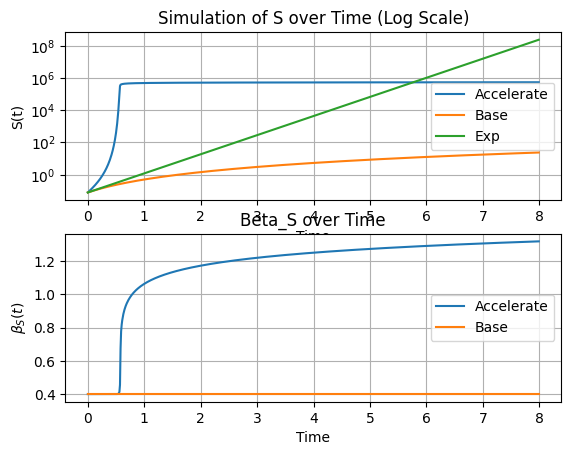

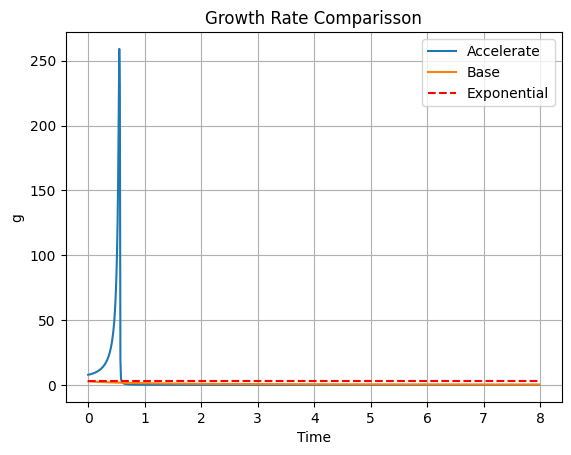

In [ ]:
# Simulation settings
delta_t = 0.01  # Time step in years
T = 8           # Total simulation time in years
time = np.arange(0, T, delta_t)  # Time vector
num_steps = len(time)

# Fixed parameters
R_bar = 1
g = 2.77

lambda_sample = 0.7
beta_0_sample = 0.4
g = 2.77
D_sample = 1e7
f_sample = 8

S_bar = (g * R_bar ** lambda_sample) ** (-1 / beta_0_sample)  # Equation (14)
R0 = f_sample ** (1 / lambda_sample) * R_bar
upsilon = R_bar * (f_sample ** (1 / lambda_sample) - 1) / S_bar

# Initialize arrays
S_valuesA = np.zeros(num_steps)
beta_SA = np.zeros(num_steps)
g_S_valuesA = np.zeros(num_steps - 1)
S_values = np.zeros(num_steps)
beta_S = np.zeros(num_steps)
g_S_values = np.zeros(num_steps - 1)
S_values_Exp = np.zeros(num_steps)

# Initial conditions
S_valuesA[0] = S_bar
beta_SA[0] = beta_0_sample
S_values[0] = S_bar
beta_S[0] = beta_0_sample
S_values_Exp[0] = S_bar

# Simulation loop
for t in range(1, num_steps):
      # Accelerated case
      beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_valuesA[t] = S_valuesA[t - 1] + delta_t * (R_bar + upsilon * S_valuesA[t - 1]) ** lambda_sample * S_valuesA[t - 1] ** (1 - beta_SA[t])

      # Non-accelerated case
      beta_S[t] = beta_0_sample * (1 - ((S_values[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_values[t] = S_values[t - 1] + delta_t * R_bar ** lambda_sample * S_values[t - 1] ** (1 - beta_S[t])

      # Exponential case
      S_values_Exp[t] = S_values_Exp[t - 1] * (1 + delta_t * g)

# Calculate Growth Rates
S_valuesA_netend = S_valuesA[:-1]
g_S_valuesA = np.diff(S_valuesA) / (S_valuesA_netend * delta_t)
S_values_netend = S_values[:-1]
g_S_values = np.diff(S_values) / (S_values_netend * delta_t)

# First subplot: Log plot of S_values over time
plt.figure(1)
plt.subplot(2, 1, 1)
plt.semilogy(time, S_valuesA, '-', label='Accelerate')
plt.semilogy(time, S_values, '-', label='Base')
plt.semilogy(time, S_values_Exp, '-', label='Exp')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Simulation of S over Time (Log Scale)')
plt.grid(True)
plt.legend()

# Second subplot: Plot of beta_S over time (not in log scale)
plt.subplot(2, 1, 2)
plt.plot(time, beta_SA, '-', label='Accelerate')
plt.plot(time, beta_S, '-', label='Base')
plt.xlabel('Time')
plt.ylabel(r'$\beta_S(t)$')
plt.title('Beta_S over Time')
plt.grid(True)
plt.legend()

# Plot Growth Rate Comparisson
plt.figure(2)
plt.plot(time[:-1], g_S_valuesA, '-', label='Accelerate')
plt.plot(time[:-1], g_S_values, '-', label='Base')
plt.plot(time[:-1], g * np.ones(len(time[:-1])), 'r--', label='Exponential')
plt.xlabel('Time')
plt.ylabel('g')
plt.title('Growth Rate Comparisson')
plt.grid(True)
plt.legend()

plt.show()


Example Calibration: Growth in Compute


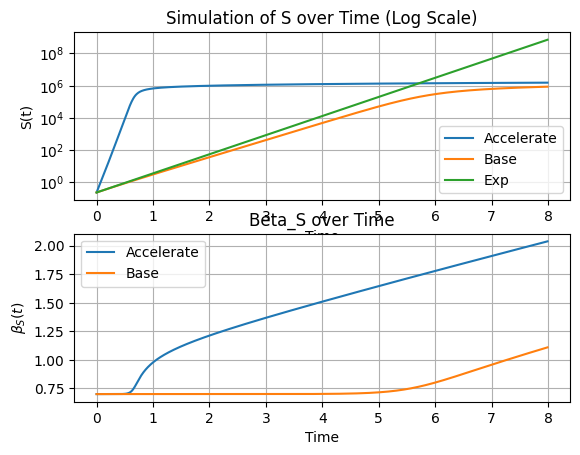

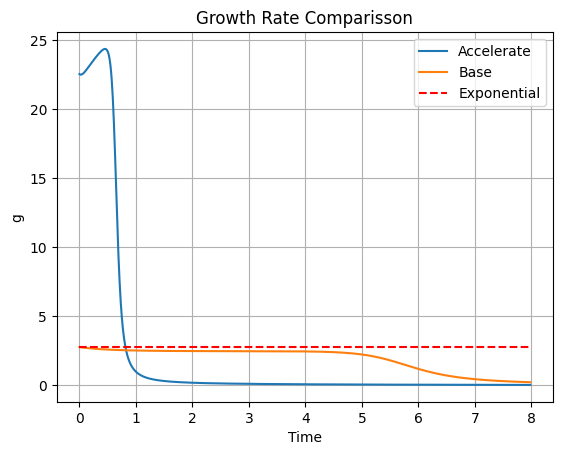

In [ ]:
# Simulation settings
delta_t = 0.01  # Time step in years
T = 8           # Total simulation time in years
time = np.arange(0, T, delta_t)  # Time vector
num_steps = len(time)

# Fixed parameters
R_bar = 1
C_0 = 1
g = 2.77
alpha=0.9

lambda_sample = 0.7
beta_0_sample = .7
g = 2.77
D_sample = 1e7
f_sample = 8

S_bar = (g * R_bar ** (-lambda_sample * alpha) * C_0 ** (-lambda_sample * (1-alpha))) ** (-1 / beta_0_sample)
R0 = f_sample ** (1 / (lambda_sample * alpha)) * R_bar
upsilon = R_bar * (f_sample ** (1 / (lambda_sample * alpha)) - 1) / S_bar

# Initialize arrays
C = np.zeros(num_steps)
Researchers = np.zeros(num_steps)
S_valuesA = np.zeros(num_steps)
beta_SA = np.zeros(num_steps)
g_S_valuesA = np.zeros(num_steps - 1)
S_values = np.zeros(num_steps)
beta_S = np.zeros(num_steps)
g_S_values = np.zeros(num_steps - 1)
S_values_Exp = np.zeros(num_steps)

# Initial conditions
C[0] = C_0
S_valuesA[0] = S_bar
beta_SA[0] = beta_0_sample
S_values[0] = S_bar
beta_S[0] = beta_0_sample
S_values_Exp[0] = S_bar
Researchers[0] = f_sample ** (1/(lambda_sample * alpha)) * R_bar
#Researchers[0] = (R_bar + upsilon * S_bar)

# Simulation loop
for t in range(1, num_steps):
      # Non-accelerated case
      beta_S[t] = beta_0_sample * (1 - ((S_values[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      C[t] = C[t-1] * (1+ delta_t * g * beta_0_sample / (lambda_sample * (1-alpha)))
      S_values[t] = S_values[t - 1] + delta_t * (R_bar ** (lambda_sample * alpha))* (C[t-1] ** (lambda_sample * (1-alpha))) * (S_values[t - 1] ** (1- beta_S[t-1]))

      # Accelerated case
      beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_valuesA[t] = S_valuesA[t - 1] + delta_t * Researchers[t-1] ** (lambda_sample * alpha) * C[t] ** (lambda_sample * (1-alpha)) * S_valuesA[t - 1] ** (1 - beta_SA[t])
      Researchers[t] = (R_bar + upsilon * S_valuesA[t])

      # Exponential case
      S_values_Exp[t] = S_values_Exp[t - 1] * (1 + delta_t * g)

# Calculate Growth Rates
S_valuesA_netend = S_valuesA[:-1]
g_S_valuesA = np.diff(S_valuesA) / (S_valuesA_netend * delta_t)
S_values_netend = S_values[:-1]
g_S_values = np.diff(S_values) / (S_values_netend * delta_t)
C_netend = C[:-1]
g_C_values = np.diff(C) / (C_netend * delta_t)

# First subplot: Log plot of S_values over time
plt.figure(1)
plt.subplot(2, 1, 1)
plt.semilogy(time, S_valuesA, '-', label='Accelerate')
plt.semilogy(time, S_values, '-', label='Base')
plt.semilogy(time, S_values_Exp, '-', label='Exp')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Simulation of S over Time (Log Scale)')
plt.grid(True)
plt.legend()

# Second subplot: Plot of beta_S over time (not in log scale)
plt.subplot(2, 1, 2)
plt.plot(time, beta_SA, '-', label='Accelerate')
plt.plot(time, beta_S, '-', label='Base')
plt.xlabel('Time')
plt.ylabel(r'$\beta_S(t)$')
plt.title('Beta_S over Time')
plt.grid(True)
plt.legend()

# Plot Growth Rate Comparisson
plt.figure(2)
plt.plot(time[:-1], g_S_valuesA, '-', label='Accelerate')
plt.plot(time[:-1], g_S_values, '-', label='Base')
plt.plot(time[:-1], g * np.ones(len(time[:-1])), 'r--', label='Exponential')
plt.xlabel('Time')
plt.ylabel('g')
plt.title('Growth Rate Comparisson')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
(R_bar * (f_sample ** (1/(lambda_sample * alpha)))) ** (lambda_sample * alpha)




7.999999999999999

Old

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Simulation settings
delta_t = 0.001  # Time step in years
T = 8           # Total simulation time in years
time = np.arange(0, T, delta_t)  # Time vector
num_steps = len(time)

# Time points of interest (in years)
time_points = [1/12, 4/12, 1, 3]  # 1 month, 4 months, 1 year, 3 years

# Parameters for distributions
lambda_min, lambda_max = 0.2, 0.8
D_min, D_max = 1e7, 1e11
beta_0_min, beta_0_max = 0.15, 0.75
f_min, f_max = 2, 32

# Fixed parameters
R_bar = 1
g = 2.77

# Number of simulations
num_simulations = 1000  # Adjust based on your computational resources

# Define the multipliers
multipliers = [1, 3, 10]

# Initialize counts over time for each multiplier
counts_over_time = np.zeros((len(multipliers), num_steps - 1))

# Loop over simulations
for sim in range(num_simulations):
# Sample parameters from log-uniform distributions
  lambda_sample = np.exp(np.random.uniform(np.log(lambda_min), np.log(lambda_max)))
  D_sample = np.exp(np.random.uniform(np.log(D_min), np.log(D_max)))
  beta_0_sample = np.exp(np.random.uniform(np.log(beta_0_min), np.log(beta_0_max)))
  f_sample = np.exp(np.random.uniform(np.log(f_min), np.log(f_max)))

  # Compute derived parameters
  S_bar = (g * R_bar ** lambda_sample) ** (1 / beta_0_sample)
  R0 = f_sample ** (1 / lambda_sample) * R_bar
  upsilon = R_bar * (f_sample ** (1 / lambda_sample) - 1) / S_bar

  # Initialize arrays
  S_valuesA = np.zeros(num_steps)
  beta_SA = np.zeros(num_steps)
  g_S_valuesA = np.zeros(num_steps - 1)

  # Initial conditions
  S_valuesA[0] = S_bar
  beta_SA[0] = beta_0_sample

  # Simulation loop
  for t in range(1, num_steps):
      beta_SA[t] = beta_0_sample * (1 - ((S_valuesA[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_valuesA[t] = S_valuesA[t - 1] + delta_t * (R_bar + upsilon * S_valuesA[t - 1]) ** lambda_sample * S_valuesA[t - 1] ** (1 - beta_SA[t])
      beta_S[t] = beta_0_sample * (1 - ((S_values[t - 1] / S_bar - 1) / (D_sample - 1))) ** (-1)
      S_values[t] = S_values[t - 1] + delta_t * R_bar ** lambda_sample * S_valuesA[t - 1] ** (1 - beta_SA[t])

  # Calculate growth rates
  S_valuesA_netend = S_valuesA[:-1]
  g_S_valuesA = np.diff(S_valuesA) / (S_valuesA_netend * delta_t)
  S_values_netend = S_values[:-1]
  g_S_values = np.diff(S_values) / (S_values_netend * delta_t)

  ###### Collect counts over time for each multiplier
  for m_idx, multiplier in enumerate(multipliers):
      counts_over_time[m_idx] += g_S_valuesA > multiplier * 2.77

# Inside the simulation loop, after computing g_S_valuesA
for idx, t_point in enumerate(time_points):
    time_idx = int(t_point / delta_t)
    if time_idx < len(g_S_valuesA):
        for m_idx, multiplier in enumerate(multipliers):
            if g_S_valuesA[time_idx] > multiplier * 2.77:
                counts[idx, m_idx] += 1

# Calculate percentages for each time point and multiplier
percentages = (counts / num_simulations) * 100

# Display the results
time_labels = ['1 Month', '4 Months', '1 Year', '3 Years']
multiplier_labels = ['1x', '3x', '10x']

for idx, t_label in enumerate(time_labels):
    for m_idx, m_label in enumerate(multiplier_labels):
        percent = percentages[idx, m_idx]
        print(f"Percentage of simulations where g_S_valuesA > {m_label} 2.77 up to {t_label}: {percent:.2f}%")

##### Calculate the fractions (CDF) over time
fractions_over_time = counts_over_time / num_simulations

    # Apply smoothing to the fractions_over_time using a moving average filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

    # Define the window size for smoothing (adjust as needed)
window_size = 70  # For example, using a window size of 50 time steps

    # Apply smoothing to each multiplier's data
fractions_smoothed = np.zeros_like(fractions_over_time)
for m_idx in range(len(multipliers)):
    fractions_smoothed[m_idx] = moving_average(fractions_over_time[m_idx], window_size)

time_mask = time[:-1] >= 0.05  # Exclude data before year 1
    # Plot the smoothed CDFs
plt.figure(figsize=(10, 6))
for m_idx, multiplier in enumerate(multipliers):
    plt.plot(time[:-1][time_mask], fractions_smoothed[m_idx][time_mask], label=f'{multiplier}x')

plt.xlabel('Years')
plt.ylabel('Fraction where growth rate > multiplier × 2.77')
plt.title('CDF of Growth Rate Exceeding Multiples of 2.77 Over Time')
plt.legend()
plt.grid(True)
plt.show()

